<a href="https://colab.research.google.com/github/AbhishekDutt/kaggle-fake-news/blob/master/fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Training Data

In [ ]:
%%bash
if [ ! -f data/fake-news.zip ]; then
  wget https://github.com/AbhishekDutt/kaggle-fake-news/raw/master/data/fake-news.zip -P data/
fi
if [ ! -f data/train.csv ]; then
  unzip data/fake-news.zip -d data/
fi
if [ ! -f model/GoogleNews-vectors-negative300.bin.gz ]; then
  wget -c https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz -P model/
fi
pip install Cython  # needed for using more workers in Word2Vec

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.model_selection import PredefinedSplit
import gensim
from gensim.models import FastText, Word2Vec
import gensim.downloader as api

In [37]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train, valid = train_test_split(data, test_size=0.2)
train = train.copy()
valid = valid.copy()

# Util Functions

In [38]:
def get_null_info(data, text, ax):
  null_columns=data.columns[data.isnull().any()]
  str = "\nTotal count: {:,}".format(len(data))
  str += "\nNULL count: {:,}".format(len(data[data.isnull().any(axis=1)]))
  str += "\nNULL %: {:.2%}".format(len(data[data.isnull().any(axis=1)])/len(data)) 
  data.isnull().sum().plot(kind="bar", title="NULL by column "+ text, ax=ax);
  ax.text(0.5,-0.35, str, size=12, ha="center",  transform=ax.transAxes)
  

In [39]:
def plot_class_hist(data, text, ax):
  ax = data["label"].value_counts().plot(kind="bar", title="Row counts by class ("+text+")", ax=ax);
  for p in ax.patches:
      width, height = p.get_width(), p.get_height()
      ax.annotate('{:.2%}'.format(height/len(data)), (p.get_x()+0.5*width, p.get_y()+height*0.9), ha='center', fontsize=15,
  color='white')

In [40]:
def box_plot(data, col, ax):
  bx = data.boxplot(column=[col], by='label', ax=ax, grid=False);
  m1 = data.groupby(['label'])[col].median().values
  m2 = data.groupby(['label'])[col].mean().values
  mL1 = ["{:,}".format(int(n)) for n in np.round(m1, 0)]
  mL2 = ["{:,}".format(int(n)) for n in np.round(m2, 0)]
  for tick in range(len(bx.get_xticklabels())):
    bx.text(tick+1.1, m1[tick], mL1[tick], color='b', weight='semibold')
    # bx.text(tick+1.1, m1[tick], mL2[tick], color='b', weight='semibold')
    

# Check for Null Data

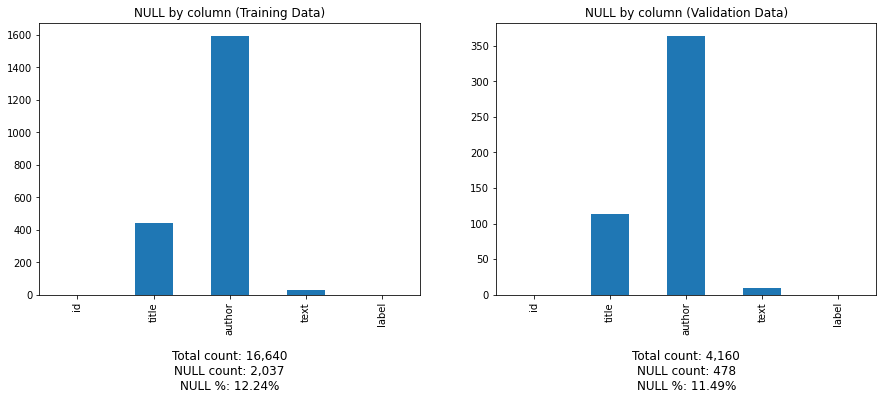

In [41]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 2, 1)
get_null_info(train, "(Training Data)", ax);
ax=fig.add_subplot(1, 2, 2)
get_null_info(valid, "(Validation Data)", ax);

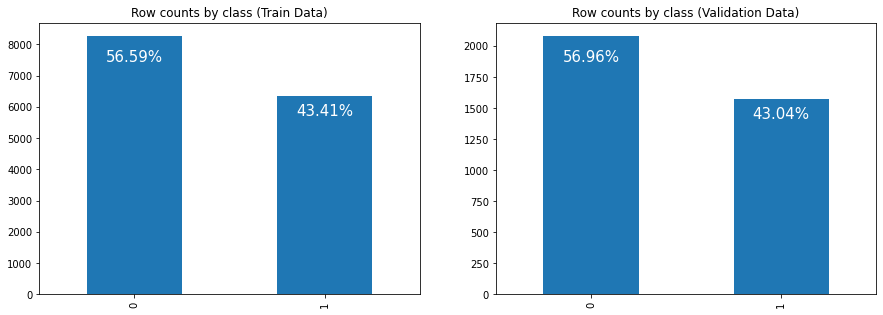

In [531]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 2, 1)
plot_class_hist(train, "Train Data", ax=ax)
ax=fig.add_subplot(1, 2, 2)
plot_class_hist(valid, "Validation Data", ax=ax)

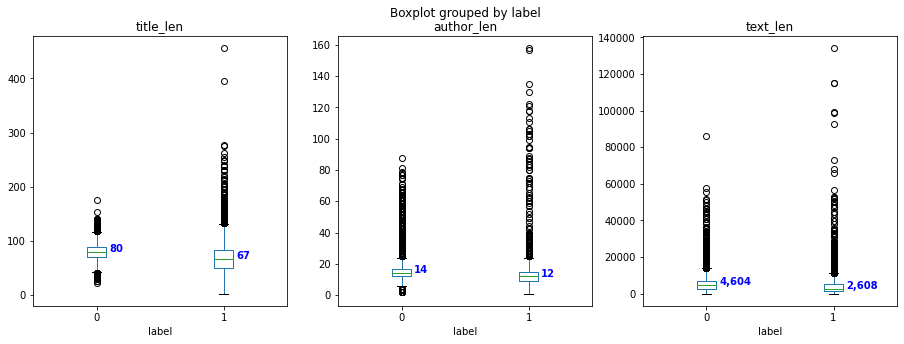

In [532]:
train['title_len'] = train['title'].str.len()
train['author_len'] = train['author'].str.len()
train['text_len'] = train['text'].str.len()

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 3, 1)
box_plot(train, 'title_len', ax)
ax=fig.add_subplot(1, 3, 2)
box_plot(train, 'author_len', ax)
ax=fig.add_subplot(1, 3, 3)
box_plot(train, 'text_len', ax)

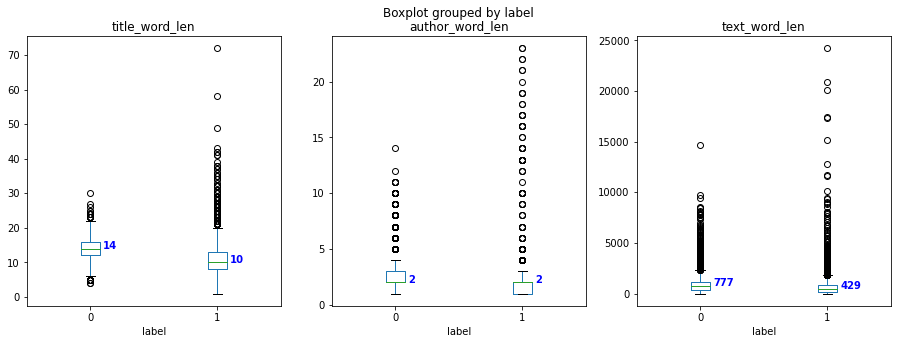

In [533]:
train['title_word_len'] = train['title'].str.split().apply(lambda x: len(x))
train['author_word_len'] = train['author'].str.split().apply(lambda x: len(x))
train['text_word_len'] = train['text'].str.split().apply(lambda x: len(x))

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 3, 1)
box_plot(train, 'title_word_len', ax)
ax=fig.add_subplot(1, 3, 2)
box_plot(train, 'author_word_len', ax)
ax=fig.add_subplot(1, 3, 3)
box_plot(train, 'text_word_len', ax)

In [534]:
train

,id,title,author,text,label,title_len,author_len,text_len,title_word_len,author_word_len,text_word_len
7698,7698,Iraqi Volunteer Forces To Help Syria Fight Ter...,Carol Adl,"Carol Adl in Middle East , News // 0 Comment...",1,53,9,1977,8,2,315
13885,13885,An Idaho Town Bucks the Perception of Rural St...,Kirk Johnson,"TWIN FALLS, Idaho — Lost jobs, empty storef...",0,73,12,7316,14,2,1266
7955,7955,$70 Million Awarded to Woman with Ovarian Canc...,Admin,Associated Press \nExcerpts: \nA St. Louis jur...,1,73,5,801,13,1,133
6769,6769,Washington Post Anti-Trump Scare Tactics,shorty,Dispatches from STEPHEN LENDMAN A s the moment...,1,40,6,4784,5,1,725
2958,2958,Turkey Referendum: Opposition Parties Cry Frau...,Frances Martel,Turkey’s opposition parties are demanding a re...,0,77,14,4089,11,2,642
...,...,...,...,...,...,...,...,...,...,...,...
502,502,President Putin Asks US To Stop Provoking Russia,Gillian,Here is President Putin’s speech at Valdai Put...,1,48,7,68208,8,1,11662
14240,14240,Iowa Berniecrat Chris Schwartz Claims That His...,Terresa Monroe-Hamilton,Iowa Berniecrat Chris Schwartz Claims That H...,1,81,23,2741,12,2,443
4719,4719,Barack Obama Tells Alexis Tsipras That Rising ...,Geoffrey Grider,Barack Obama Tells Alexis Tsipras That Risin...,1,95,15,4019,16,2,662
14100,14100,"After Baton Rouge Flooding, Learning Lessons F...",Campbell Robertson and Alan Blinder,"BATON ROUGE, La. — Darren McKinney knows ab...",0,82,35,6751,14,5,1153


# Preprocessing

In [50]:
train['all_text'] = train['title'].fillna("") + train['author'].fillna("") + train['text'].fillna("")
valid['all_text'] = valid['title'].fillna("") + valid['author'].fillna("") + valid['text'].fillna("")

In [51]:
x_train = train['all_text']
x_valid = valid['all_text']
y_train = train['label']
y_valid = valid['label']

# Word Embedding:

In [ ]:
SEQUENCE_LENGTH = 500

In [ ]:
%%time
# Count Vectors
from sklearn.feature_extraction.text import CountVectorizer
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 1), stop_words = 'english')

ctv.fit( x_train )
x_train_ctv = ctv.transform( x_train )
x_valid_ctv = ctv.transform( x_valid )

svd = TruncatedSVD(n_components=SEQUENCE_LENGTH)
svd.fit( x_train_ctv )
x_train_ctv_svd = svd.transform(x_train_ctv)
x_valid_ctv_svd = svd.transform(x_valid_ctv)

In [ ]:
%%time
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
        stop_words = 'english')
tfv.fit( x_train )
x_train_tfv = tfv.transform(x_train)
x_valid_tfv = tfv.transform(x_valid)

svd = TruncatedSVD(n_components=SEQUENCE_LENGTH)
svd.fit( x_train_tfv )
x_train_tfv_svd = svd.transform(x_train_tfv)
x_valid_tfv_svd = svd.transform(x_valid_tfv)

In [ ]:
%%time
# word2vec
x_train_tmp = x_train.apply(lambda x: x.lower().split())
x_valid_tmp = x_valid.apply(lambda x: x.lower().split())

WORD2VEC_SIZE = 300
# vectorizer = Word2Vec(x_train, size=WORD2VEC_SIZE, window=5, min_count=5, workers=4, sg=1, iter=5)
vectorizer = gensim.models.KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# Convert a sentence to a word2vec vector
def to_vector(sentence):
  words = [word for word in sentence if word in vectorizer.vocab]
  if words:
    return np.mean(vectorizer[words], axis=0)
  else:
    return np.zeros(WORD2VEC_SIZE)
    
x_train_w2v = np.array([to_vector(sentence) for sentence in x_train_tmp])
x_valid_w2v = np.array([to_vector(sentence) for sentence in x_valid_tmp])

In [22]:
%%time
# FastText (Skipped: Takes long time)
# x_train_tmp = x_train.apply(lambda x: x.split())
# x_valid_tmp = x_valid.apply(lambda x: x.split())

# FASTTEXT_SIZE = 300
# vectorizer = FastText(size=FASTTEXT_SIZE, window=20, min_count=3, sg=1, iter=5)
# vectorizer.build_vocab(x_train_tmp)
# vectorizer.train(x_train_tmp, total_examples=vectorizer.corpus_count, epochs=vectorizer.epochs)

# def to_vector(sentence):
#   words = [word for word in sentence if word in vectorizer.wv.vocab]
#   if words:
#     return np.mean(vectorizer.wv[words], axis=0)
#   else:
#     return np.zeros(FASTTEXT_SIZE)
    
# x_train_fasttext = np.array([to_vector(sentence) for sentence in x_train_tmp])
# x_valid_fasttext = np.array([to_vector(sentence) for sentence in x_valid_tmp])

CPU times: user 3min 23s, sys: 1.16 s, total: 3min 24s
Wall time: 1min 49s


In [30]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

ensemble_clf=[
  LogisticRegression(penalty='none', C=1, solver='lbfgs', max_iter=5000, n_jobs=-1),
  KNeighborsClassifier(n_jobs=-1),
  SVC(C=1.0, probability=False),
  RandomForestClassifier(),
  XGBClassifier(objective='binary:logistic', eval_metric='error')
] 
parameters_list = [
  {'penalty' : ['l1', 'l2', 'none'], 'C' : [1, 0.5, 0.1], 'solver' : ['liblinear']},
  {'n_neighbors':range(1, 21, 2), 'weights':['uniform', 'distance'], 'metric':['euclidean', 'manhattan', 'minkowski']},
  # {'n_neighbors':range(1, 10, 5)},
  {'kernel':['poly', 'rbf', 'sigmoid'], 'C':[50, 10, 1.0, 0.1, 0.01], 'gamma':['scale']}
  # {'kernel':['poly', 'rbf'], 'C':[50, 0.01], 'gamma':['scale']},
  # {'n_estimators':[10, 100, 1000], 'max_features':['sqrt', 'log2']},
  {'n_estimators':[50], 'max_features':['sqrt', 'log2']},
  {'max_depth':[2, 6]}
]

results = []
wv = [
  # (x_train_ctv_svd, y_train, x_valid_ctv_svd, y_valid),
  (x_train_tfv_svd, y_train, x_valid_tfv_svd, y_valid),
  # (x_train_w2v, y_train, x_valid_w2v, y_valid),
  # (x_train_fasttext, y_train, x_valid_fasttext, y_valid)
]
for train_data in wv:
  train_x, train_y, valid_x, valid_y = train_data
  for i in range(len(ensemble_clf)):
    grid = GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=3, scoring='accuracy', verbose=3)
    grid.fit(train_x, train_y)
    print("==================")
    print(grid.best_params_)
    print("CV acc: " + grid.best_score_)
    results.append({
      "best_params": grid.best_params_, 
      "best_score": grid.best_score_,
      "best_estimator_": grid.best_estimator_
    })
    y_train_pred = results[i]['best_estimator_'].predict(train_x)
    train_acc = accuracy_score(train_y, y_train_pred, normalize=True)
    print("Train acc: " + train_acc)
    y_valid_pred = results[i]['best_estimator_'].predict(valid_x)
    valid_acc = accuracy_score(valid_y, y_valid_pred, normalize=True)
    print("Valid acc: " + valid_acc)
    print("==================")


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   39.3s finished


{'max_features': 'sqrt', 'n_estimators': 50}
0.9377905386929176
0.9998632759092152
0.9294503691550451
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.8min finished


{'max_depth': 6}
0.9561115668580804
0.9991112934098988
0.9526934645884605
CPU times: user 1min 58s, sys: 457 ms, total: 1min 58s
Wall time: 6min 26s


In [24]:
x_train_fasttext.shape

(500, 300)

In [70]:
%%time
knn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
model = knn.fit(xtrain_ctv_svd, y_train)
y_valid_pred = model.predict(xvalid_ctv_svd)
valid_acc = accuracy_score(y_valid, y_valid_pred, normalize=True)
print(valid_acc)

0.8589007383100903
CPU times: user 1min 3s, sys: 19.2 ms, total: 1min 3s
Wall time: 33 s


In [73]:
%%time
svm = SVC(C=1.0, probability=False)
model = svm.fit(xtrain_ctv_svd, y_train)
y_valid_pred = model.predict(xvalid_ctv_svd)
valid_acc = accuracy_score(y_valid, y_valid_pred, normalize=True)
print(valid_acc)

0.9360131255127153
CPU times: user 1min 27s, sys: 36.5 ms, total: 1min 27s
Wall time: 1min 27s


In [140]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, max_features='sqrt')
model = rf.fit(x_train_w2v, y_train)
y_valid_pred = model.predict(x_vaild_w2v)
valid_acc = accuracy_score(y_valid, y_valid_pred, normalize=True)
print(valid_acc)

0.8310090237899918
CPU times: user 2.67 s, sys: 3 ms, total: 2.68 s
Wall time: 2.68 s


In [92]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=2, objective='binary:logistic', eval_metric='error')
model = xgb.fit(xtrain_ctv_svd, y_train)
y_valid_pred = model.predict(xvalid_ctv_svd)
valid_acc = accuracy_score(y_valid, y_valid_pred, normalize=True)
print(valid_acc)

0.8709324582991523
CPU times: user 31.6 s, sys: 9.15 ms, total: 31.6 s
Wall time: 31.7 s
